In [59]:
# ==========================
# 0) Parametri di ingresso
# ==========================
DATA_PATH = 'Dataset/loan_data.csv' 
TARGET = 'loan_status' 

# Opzioni CV
N_SPLITS = 5
RANDOM_STATE = 42

print('Percorso dati:', DATA_PATH)
print('Colonna target:', TARGET)

Percorso dati: Dataset/loan_data.csv
Colonna target: loan_status


In [60]:
# 1) Import e setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


pd.set_option('display.max_columns', 200)

In [61]:
# 2) Caricamento dati
path = Path(DATA_PATH)
assert path.exists(), f"File non trovato: {path.resolve()}"
df = pd.read_csv(path)
print('Shape iniziale:', df.shape)
df.head()

Shape iniziale: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [62]:
drop_cols = ["previous_loan_defaults_on_file"]

# Rimuovo le colonne
df = df.drop(columns=drop_cols)
print("Shape dopo esclusione colonne:", df.shape)

Shape dopo esclusione colonne: (45000, 13)


Shape: (45000, 13)

Tipi colonna:


,dtype
person_age,float64
person_gender,object
person_education,object
person_income,float64
person_emp_exp,int64
person_home_ownership,object
loan_amnt,float64
loan_intent,object
loan_int_rate,float64
loan_percent_income,float64



Distribuzione target (counts):


loan_status
0    35000
1    10000
Name: count, dtype: int64


Distribuzione target (ratio):


loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


Baseline AUPRC (prevalenza positivi): 0.2222


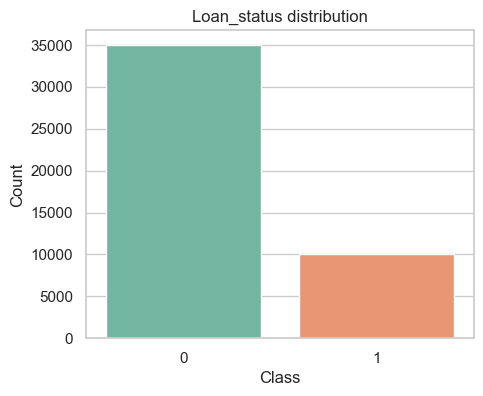


Valori mancanti (prime 20 colonne):


,n_missing
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


Nessun valore mancante rilevato.

Cardinalità variabili categoriche:


,n_unique
loan_intent,6
person_education,5
person_home_ownership,4
person_gender,2



Top categorie (prime 10 per colonna):

▶ person_gender


person_gender
male      24841
female    20159
Name: count, dtype: int64


▶ person_education


person_education
Bachelor       13399
Associate      12028
High School    11972
Master          6980
Doctorate        621
Name: count, dtype: int64


▶ person_home_ownership


person_home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64


▶ loan_intent


loan_intent
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

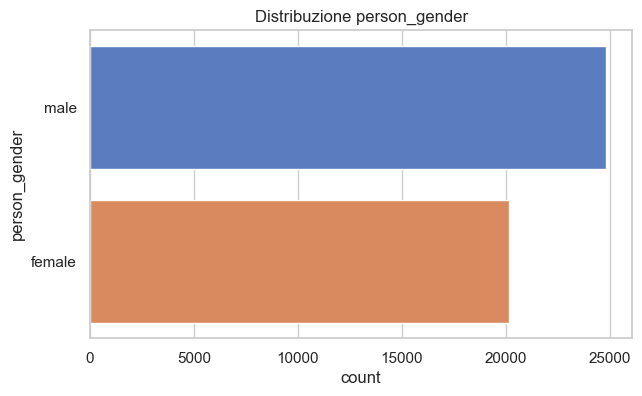

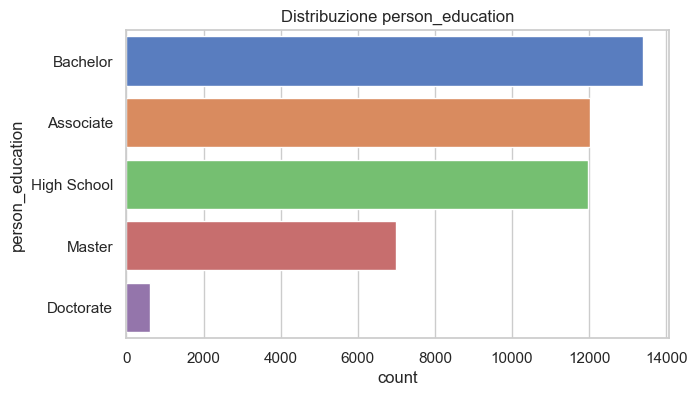

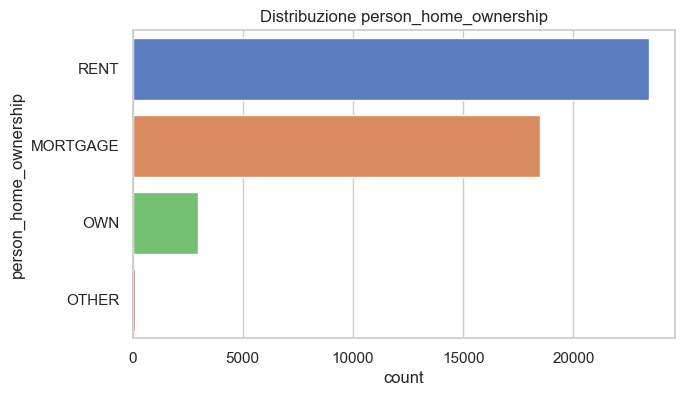

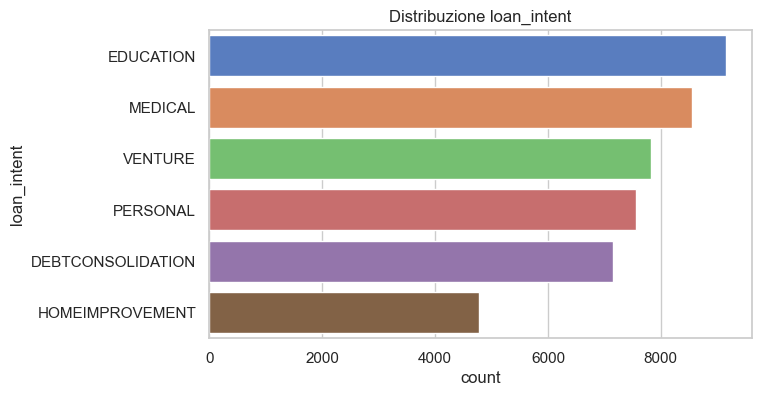


Statistiche descrittive numeriche:


,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00



% outlier (regola IQR) – top 20:


,% outlier
loan_amnt,0.052178
person_income,0.049289
person_age,0.048622
person_emp_exp,0.038311
cb_person_cred_hist_length,0.030356
loan_percent_income,0.016533
credit_score,0.010378
loan_int_rate,0.002756



Correlazione con il target (numeriche):


,corr_with_target
loan_percent_income,0.384880
loan_int_rate,0.332005
loan_amnt,0.107714
credit_score,-0.007647
cb_person_cred_hist_length,-0.014851
person_emp_exp,-0.020481
person_age,-0.021476
person_income,-0.135808


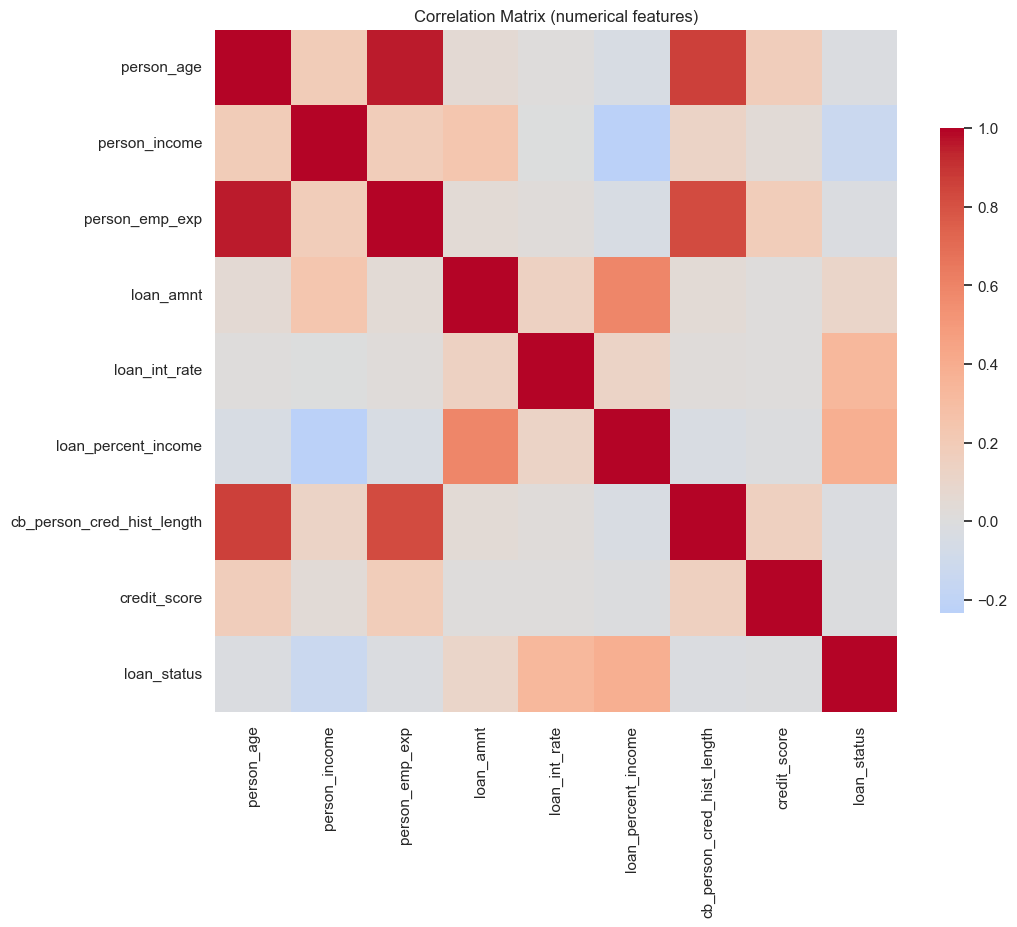

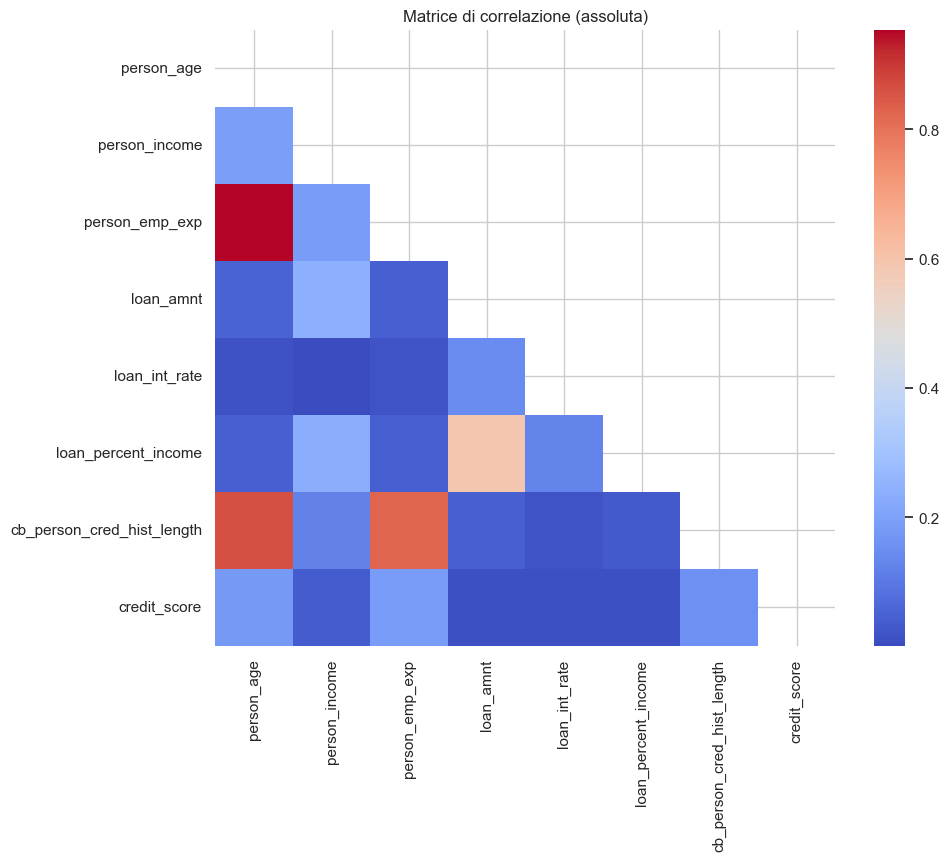


Coppie di feature altamente correlate (|r|>=0.95):


,feat1,feat2,corr
0,person_age,person_emp_exp,0.954412


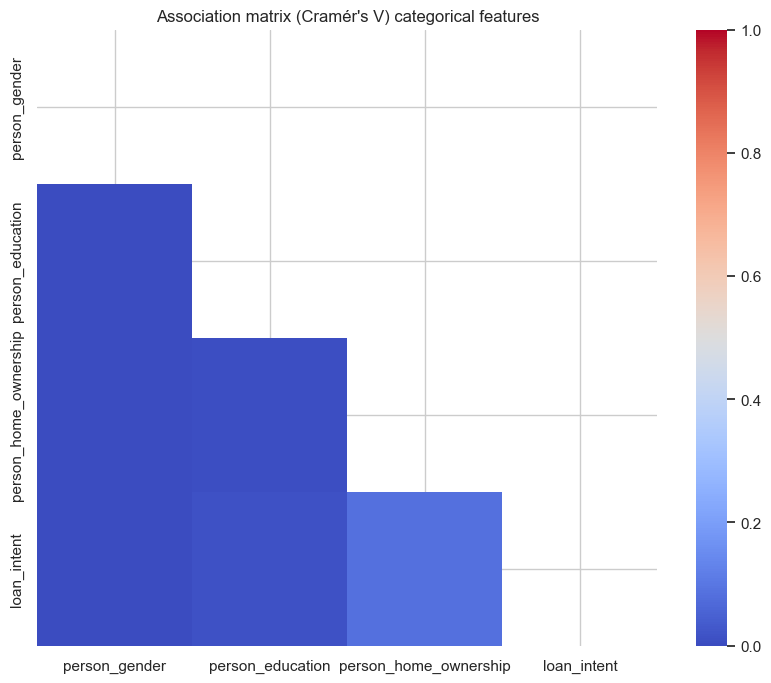


✅ EDA completata.


In [63]:
# ==========================
# EDA COMPLETA AMPLIATA
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency  # ← aggiunta per Cramér's V

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# 0) Info generali
print("Shape:", df.shape)
print("\nTipi colonna:")
display(df.dtypes.to_frame("dtype"))

# 1) Distribuzione target
print("\nDistribuzione target (counts):")
display(df[TARGET].value_counts(dropna=False))
print("\nDistribuzione target (ratio):")
display(df[TARGET].value_counts(normalize=True, dropna=False))

# baseline AUPRC = prevalenza positivi
pos_ratio = df[TARGET].mean() if pd.api.types.is_numeric_dtype(df[TARGET]) else (df[TARGET] == 1).mean()
print(f"\nBaseline AUPRC (prevalenza positivi): {pos_ratio:.4f}")

# Grafico distribuzione target
plt.figure(figsize=(5,4))
sns.countplot(x=TARGET, data=df, palette="Set2")
plt.title("Loan_status distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 2) Missing values
missing = df.isna().sum().sort_values(ascending=False)
print("\nValori mancanti (prime 20 colonne):")
display(missing.head(20).to_frame("n_missing"))
if missing.sum() == 0:
    print("Nessun valore mancante rilevato.")
else:
    (missing/len(df)).plot(kind="bar", title="Percentuale missing per colonna (solo colonne con NaN)")
    plt.ylabel("Percentuale")
    plt.show()

# 3) Cardinalità variabili categoriche
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nCardinalità variabili categoriche:")
card = pd.Series({c: df[c].nunique(dropna=False) for c in cat_cols}).sort_values(ascending=False)
display(card.to_frame("n_unique"))

print("\nTop categorie (prime 10 per colonna):")
for c in cat_cols[:10]:
    print(f"\n▶ {c}")
    display(df[c].value_counts(dropna=False).head(10))

# Grafici distribuzione categoriche principali
main_cat = cat_cols[:5]
for c in main_cat:
    plt.figure(figsize=(7,4))
    sns.countplot(y=c, data=df, order=df[c].value_counts().index, palette="muted")
    plt.title(f"Distribuzione {c}")
    plt.show()

# 4) Summary numeriche + outlier check
num_cols = df.select_dtypes(include=[np.number]).columns.drop([TARGET], errors="ignore").tolist()
print("\nStatistiche descrittive numeriche:")
display(df[num_cols].describe().T)

# skewness → suggerisce log-transform
#skew_s = df[num_cols].skew(numeric_only=True).sort_values(ascending=False)
#print("\nSkewness (prime 20, alto→basso):")
#display(skew_s.head(20).to_frame("skew"))
#log_candidates = [c for c in skew_s.index if skew_s[c] > 0.8 and (df[c] > 0).all()]
#print("\nCandidati log-transform (skew>0.8 e valori >0):", log_candidates[:20])

# outlier (IQR rule)
iqr_out = {}
for c in num_cols:
    q1, q3 = np.percentile(df[c].dropna(), [25, 75])
    iqr = q3 - q1
    if iqr == 0:
        continue
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    pct = ((df[c] < low) | (df[c] > high)).mean()
    iqr_out[c] = pct
out_df = pd.Series(iqr_out).sort_values(ascending=False).head(20).to_frame("% outlier")
print("\n% outlier (regola IQR) – top 20:")
display(out_df)

# 5) Correlazioni numeriche (con target se numerico)
if pd.api.types.is_numeric_dtype(df[TARGET]):
    corr = df[num_cols + [TARGET]].corr(numeric_only=True)
    print("\nCorrelazione con il target (numeriche):")
    target_corr = corr[TARGET].drop(index=[TARGET]).sort_values(ascending=False)
    display(target_corr.to_frame("corr_with_target").head(20))

    plt.figure(figsize=(11, 9))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .7})
    plt.title("Correlation Matrix (numerical features)")
    plt.show()

    # heatmap più leggibile (solo correlazioni assolute)
    plt.figure(figsize=(10,8))
    top_corr = df[num_cols].corr().abs()
    mask = np.triu(np.ones_like(top_corr, dtype=bool))
    sns.heatmap(top_corr, mask=mask, cmap="coolwarm", annot=False, cbar=True)
    plt.title("Matrice di correlazione (assoluta)")
    plt.show()

    # coppie altamente correlate
    high_pair = []
    for i, c1 in enumerate(num_cols):
        for c2 in num_cols[i+1:]:
            r = corr.loc[c1, c2]
            if abs(r) >= 0.95:
                high_pair.append((c1, c2, r))
    if high_pair:
        print("\nCoppie di feature altamente correlate (|r|>=0.95):")
        display(pd.DataFrame(high_pair, columns=["feat1", "feat2", "corr"]).sort_values("corr", ascending=False))
    else:
        print("\nNessuna coppia di feature con |correlazione| ≥ 0.95.")
else:
    print("\nIl target non è numerico → salta correlazione con il target.")

# 5-b) Associazioni tra categoriche (Cramér's V) – heatmap simile a quella numerica
if len(cat_cols) > 1:
    def cramers_v(x, y):
        confusion = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion)[0]
        n = confusion.sum().sum()
        phi2 = chi2 / n
        r, k = confusion.shape
        # correzione di bias per tabelle non quadrate / piccole
        phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
        rcorr = r - (r-1)**2/(n-1)
        kcorr = k - (k-1)**2/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for c1 in cat_cols:
        for c2 in cat_cols:
            cramer_matrix.loc[c1, c2] = 1.0 if c1 == c2 else cramers_v(df[c1], df[c2])

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(cramer_matrix, dtype=bool))
    sns.heatmap(cramer_matrix, mask=mask, cmap="coolwarm", vmin=0, vmax=1, cbar=True)
    plt.title("Association matrix (Cramér's V) categorical features")
    plt.show()
else:
    print("\nPoche o nessuna variabile categorica → salta Cramér's V.")

"""
# 6) Leakage checks
nunique = df.nunique(dropna=False)
const_like = nunique[nunique <= 1].index.tolist()
if const_like:
    print("\nColonne costanti/quasi costanti:", const_like)

dup_cols = []
seen = {}
for c in df.columns:
    key = tuple(df[c].fillna("__NA__").values)
    if key in seen:
        dup_cols.append((c, seen[key]))
    else:
        seen[key] = c
if dup_cols:
    print("\nColonne duplicate (stesso contenuto):")
    display(pd.DataFrame(dup_cols, columns=["col", "duplicata_di"]))

# 7) Grafici numeriche
sample_num = num_cols[:6]
if sample_num:
    df[sample_num].hist(bins=30, figsize=(14, 8))
    plt.suptitle("Distribuzioni (subset numeriche)")
    plt.show()

    # violin plot numeriche vs target
    if pd.api.types.is_numeric_dtype(df[TARGET]) and df[TARGET].nunique() == 2:
        for c in sample_num:
            plt.figure(figsize=(8, 4))
            sns.violinplot(x=TARGET, y=c, data=df, palette="Set3", inner="quartile")
            plt.title(f"{c} vs Target")
            plt.show()
"""

print("\n✅ EDA completata.")


In [64]:
# 3) Pulizia di base
df = df.drop_duplicates()
print('Shape dopo drop_duplicates:', df.shape)

# Controllo target
if TARGET not in df.columns:
    raise ValueError(f"La colonna target '{TARGET}' non esiste. Colonne: {list(df.columns)}")

# Analisi preliminare
missing_total = df.isna().sum().sum()
missing_per_col = df.isna().sum().sort_values(ascending=False)
print('Missing totali:', missing_total)
display(missing_per_col[missing_per_col>0].to_frame('n_missing').head(20))

# Distribuzione target
target_counts = df[TARGET].value_counts(dropna=False)
target_ratio = df[TARGET].value_counts(normalize=True, dropna=False)
print('\nDistribuzione target (counts):')
display(target_counts)
print('\nDistribuzione target (ratio):')
display(target_ratio)

# Tipi colonna
display(df.dtypes.to_frame('dtype').head(40))

Shape dopo drop_duplicates: (45000, 13)
Missing totali: 0


,n_missing



Distribuzione target (counts):


loan_status
0    35000
1    10000
Name: count, dtype: int64


Distribuzione target (ratio):


loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64

,dtype
person_age,float64
person_gender,object
person_education,object
person_income,float64
person_emp_exp,int64
person_home_ownership,object
loan_amnt,float64
loan_intent,object
loan_int_rate,float64
loan_percent_income,float64


In [65]:
# 4) Rilevazione di colonne numeriche/categoriche + eventuali colonne costanti o duplicate
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()
print('ciao')

if TARGET in numerical_features:
    numerical_features.remove(TARGET)
if TARGET in categorical_features:
    categorical_features.remove(TARGET)

print('Num features numeriche:', len(numerical_features))
print('Num features categoriche:', len(categorical_features))

# Colonne costanti
nunique = df.drop(columns=[TARGET]).nunique()
constant_cols = nunique[nunique<=1].index.tolist()
if constant_cols:
    print('[INFO] Colonne costanti trovate e rimosse:', constant_cols)
    df = df.drop(columns=constant_cols)
    numerical_features = [c for c in numerical_features if c not in constant_cols]
    categorical_features = [c for c in categorical_features if c not in constant_cols]

# Colonne duplicate (stesso contenuto)
dup_cols = []
cols = [c for c in df.columns if c != TARGET]
seen = {}
for c in cols:
    key = tuple(df[c].values)
    if key in seen:
        dup_cols.append(c)
    else:
        seen[key] = c
if dup_cols:
    print('[INFO] Colonne duplicate trovate e rimosse:', dup_cols)
    df = df.drop(columns=dup_cols)
    numerical_features = [c for c in numerical_features if c not in dup_cols]
    categorical_features = [c for c in categorical_features if c not in dup_cols]

print('Shape dopo pulizia colonne:', df.shape)

ciao
Num features numeriche: 8
Num features categoriche: 4
Shape dopo pulizia colonne: (45000, 13)


In [66]:
# === LOG TRANSFORMATION DETECTOR ===
log_cols = []
skew_threshold = 0.5  # alza a 1.0 se vuoi essere più conservativa
for col in numerical_features:
    # Consideriamo solo colonne con valori strettamente positivi
    if (df[col] > 0).all():
        skewness = df[col].skew()
        if skewness > skew_threshold:
            log_cols.append(col)
            print(f"[LOG-TRANSFORM] {col} → skew={skewness:.2f}")

if log_cols:
    import numpy as np
    print('Applico log1p su:', log_cols)
    df[log_cols] = np.log1p(df[log_cols])
else:
    print('Nessuna colonna con skewness > soglia per log-transform')

[LOG-TRANSFORM] person_age → skew=2.55
[LOG-TRANSFORM] person_income → skew=34.14
[LOG-TRANSFORM] loan_amnt → skew=1.18
[LOG-TRANSFORM] cb_person_cred_hist_length → skew=1.63
Applico log1p su: ['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']


In [67]:
# 5) Preprocessing pipelines
# A) Preprocess per RF/GB/XGB: numeriche imputate+scalate, categoriche OHE
num_transformer_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor_ohe = ColumnTransformer(transformers=[
    ('num', num_transformer_ohe, numerical_features),
    ('cat', cat_transformer_ohe, categorical_features)
])

# B) Preprocess per CatBoost: numeriche imputate, categoriche imputate ma NON OHE
#    (CatBoost gestisce le categoriche in modo nativo). Qui NON usiamo scaler.
num_transformer_cat = SimpleImputer(strategy='median')
cat_transformer_cat = SimpleImputer(strategy='most_frequent')
preprocessor_cat = ColumnTransformer(transformers=[
    ('num', num_transformer_cat, numerical_features),
    ('cat', cat_transformer_cat, categorical_features)
])

# Indici delle colonne categoriche nel vettore trasformato da preprocessor_cat
cat_idx = list(range(len(numerical_features), len(numerical_features) + len(categorical_features)))
print('Indici categoriche per CatBoost:', cat_idx)
print('Preprocessors pronti.')

Indici categoriche per CatBoost: [8, 9, 10, 11]
Preprocessors pronti.


In [68]:
# 7) Preparazione X, y e definizione scorer
X = df.drop(columns=[TARGET])
y = df[TARGET]

if y.dtype == 'O':
    # mapping binario (es. No/Yes -> 0/1) se possibile
    y_unique = sorted(y.dropna().unique().tolist())
    if len(y_unique) == 2:
        mapping = {y_unique[0]: 0, y_unique[1]: 1}
        y = y.map(mapping)
        print('Mapping target:', mapping)
    else:
        print('[ATTENZIONE] Target non binario o mapping non ovvio:', y_unique)

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
print('Class balance:', y.value_counts(normalize=True).to_dict())

# Peso per class imbalance (CatBoost)
n_pos = (y == 1).sum()
n_neg = (y == 0).sum()
if n_pos > 0:
    catboost_pos_weight = n_neg / n_pos
else:
    catboost_pos_weight = 1.0
print("scale_pos_weight per CatBoost:", catboost_pos_weight)




Class balance: {0: 0.7777777777777778, 1: 0.2222222222222222}
scale_pos_weight per CatBoost: 3.5


In [69]:
# 6) Modelli di classificazione (con SMOTE per RF/GB/XGB; CatBoost senza SMOTE)
models = {
    'Random Forest': (
        preprocessor_ohe,
        RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1),
        True   # usa SMOTE
    ),
    'Gradient Boosting': (
        preprocessor_ohe,
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        True   # usa SMOTE
    ),
    'XGBoost': (
        preprocessor_ohe,
        XGBClassifier(
            random_state=RANDOM_STATE,
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            eval_metric='logloss',
            tree_method='hist'
        ),
        True   # usa SMOTE
    ),
    'CatBoost (native cats)': (
        preprocessor_cat,
        CatBoostClassifier(
            iterations=600,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            random_state=RANDOM_STATE,
            verbose=0,
            cat_features=cat_idx,
            scale_pos_weight=float(catboost_pos_weight)  # gestisce lo sbilanciamento
        ),
        False  # niente SMOTE qui
    )
}

list(models.keys())


['Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost (native cats)']

In [70]:
# 8) Valutazione dei modelli con cross-validation
rows = []
for name, (preproc, model, use_smote) in models.items():
    if use_smote:
        pipe = ImbPipeline(steps=[
            ('preprocessor', preproc),
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('model', model)
        ])
    else:
        pipe = Pipeline(steps=[
            ('preprocessor', preproc),
            ('model', model)
        ])

    scores = cross_validate(
        pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    rows.append({
        'Model': name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1': scores['test_f1'].mean(),
        'ROC_AUC': scores['test_roc_auc'].mean(),
        'Accuracy_std': scores['test_accuracy'].std(),
        'F1_std': scores['test_f1'].std(),
        'ROC_AUC_std': scores['test_roc_auc'].std()
    })

results = pd.DataFrame(rows).sort_values('ROC_AUC', ascending=False).reset_index(drop=True)
results


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,Accuracy_std,F1_std,ROC_AUC_std
0,XGBoost,0.913800,0.891381,0.6971,0.782331,0.934917,0.001820,0.004674,0.002552
1,CatBoost (native cats),0.885778,0.720458,0.7945,0.755618,0.932781,0.004193,0.007788,0.002405
2,Random Forest,0.903889,0.833562,0.7092,0.766347,0.921751,0.002762,0.006006,0.002060
3,Gradient Boosting,0.887778,0.755404,0.7325,0.743663,0.911018,0.002925,0.005526,0.002413


In [71]:
# 9) Fit finale sul modello migliore + feature importances se disponibili
best_name = results.iloc[0]['Model']
best_preproc, best_model, use_smote = models[best_name]

if use_smote:
    final_pipe = ImbPipeline(steps=[
        ('preprocessor', best_preproc),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', best_model)
    ])
else:
    final_pipe = Pipeline(steps=[
        ('preprocessor', best_preproc),
        ('model', best_model)
    ])

final_pipe.fit(X, y)
print('Miglior modello:', best_name)


# Prova a ricostruire i nomi feature post-preprocessing per RF/XGB/GB
def get_feature_names_from_preprocessor(preproc, num_cols, cat_cols):
    names = []
    for name, trans, cols in preproc.transformers_:
        if name == 'num':
            # numeriche: stessa cardinalità
            names.extend(cols)
        elif name == 'cat':
            if hasattr(trans, 'named_steps') and 'ohe' in trans.named_steps:
                ohe = trans.named_steps['ohe']
                names.extend(ohe.get_feature_names_out(cols))
            else:
                names.extend(cols)
    return names

feat_names = get_feature_names_from_preprocessor(best_preproc, numerical_features, categorical_features)

importances_df = None
model_obj = final_pipe.named_steps['model']
if hasattr(model_obj, 'feature_importances_') and len(feat_names) == len(model_obj.feature_importances_):
    importances_df = pd.DataFrame({'feature': feat_names, 'importance': model_obj.feature_importances_})
    display(importances_df.sort_values('importance', ascending=False).head(30))
else:
    print('[INFO] Il modello migliore non espone feature_importances_ compatibili oppure il numero di feature non coincide.')

Miglior modello: XGBoost


,feature,importance
18,person_home_ownership_RENT,0.210430
17,person_home_ownership_OWN,0.078219
5,loan_percent_income,0.077845
24,loan_intent_VENTURE,0.064429
19,loan_intent_DEBTCONSOLIDATION,0.055865
4,loan_int_rate,0.054306
15,person_home_ownership_MORTGAGE,0.046040
21,loan_intent_HOMEIMPROVEMENT,0.045988
20,loan_intent_EDUCATION,0.042025
6,cb_person_cred_hist_length,0.039537


## Note
- **CatBoost** usa `cat_features=cat_idx`, dove `cat_idx` corrisponde agli indici delle categoriche **dopo** il `preprocessor_cat` (numeriche prima, categoriche dopo).
- Per **XGBoost/RF/GB** manteniamo OHE + scaling numerico.
- Se il dataset è **sbilanciato**, valuta class weights (`scale_pos_weight` per XGBoost, `class_weight='balanced'` per RF/GB) e metriche come AUPRC.
- Per evitare overfitting, usa **StratifiedKFold**, **early stopping** su XGBoost/CatBoost, e mantieni un **hold‑out** finale per la stima indipendente.